In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from datetime import datetime
import scipy
import tzlocal
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python2.7/dist-packages/matplotlib/__init__.py:874: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


<h2>Первичный анализ данных</h2>

In [2]:
data = pd.read_csv('fake.csv')
data.shape

(12999, 20)

In [3]:
data.head()

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689,Muslims BUSTED: They Stole Millions In Gov’t B...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689,Re: Why Did Attorney General Loretta Lynch Ple...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,0,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,25689,BREAKING: Weiner Cooperating With FBI On Hilla...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,0,Fed Up,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,english,2016-11-01T15:46:26.304+02:00,100percentfedup.com,US,25689,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,0.068,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,0,Fed Up,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,english,2016-11-01T23:59:42.266+02:00,100percentfedup.com,US,25689,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0.865,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias


In [284]:
data.isnull().sum()

uuid                     0
ord_in_thread            0
author                2424
published                0
title                  680
text                    46
language                 0
crawled                  0
site_url                 0
country                176
domain_rank           4223
thread_title            12
spam_score               0
main_img_url          3643
replies_count            0
participants_count       0
likes                    0
comments                 0
shares                   0
type                     0
dtype: int64

In [4]:
dtype_df = data.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

dtype_df.loc[:,:]

,Count,Column Type
0,uuid,object
1,ord_in_thread,int64
2,author,object
3,published,object
4,title,object
5,text,object
6,language,object
7,crawled,object
8,site_url,object
9,country,object


<p>Выдвигаем гиипотезу, что отутствие данных коррелирует с вероятность появления фейковой новости</p>

In [6]:
data['country'].unique()

array(['US', 'CO', 'FR', 'DE', 'GB', 'CA', 'AU', 'EU', 'NL', 'LI', 'SG',
       'IO', 'ME', 'TV', 'ES', 'RU', 'IN', nan, 'IR', 'EE', 'SE', 'ZA',
       'IS', 'BG', 'CH'], dtype=object)

In [7]:
data['language'].unique()

array(['english', 'ignore', 'german', 'french', 'spanish', 'russian',
       'greek', 'finnish', 'portuguese', 'arabic', 'dutch', 'italian',
       'turkish', 'norwegian', 'chinese', 'polish'], dtype=object)

In [9]:
data['uuid'] # удаляем все уникальны

0        6a175f46bcd24d39b3e962ad0f29936721db70db
1        2bdc29d12605ef9cf3f09f9875040a7113be5d5b
2        c70e149fdd53de5e61c29281100b9de0ed268bc3
3        7cf7c15731ac2a116dd7f629bd57ea468ed70284
4        0206b54719c7e241ffe0ad4315b808290dbe6c0f
5        8f30f5ea14c9d5914a9fe4f55ab2581772af4c31
6        d3cc0fe38f41a59f7c48f8c3528ca5f74193148f
7        b4bbf8b5c19e8864f5257832a58b81ef4ed2d4e4
8        a19aabaa5a61eb8bc22fadaaa003e5fbba5c4bf6
9        f54d8e13010d0a79893995ee65360ad4b38b5a35
10       4d3faf17519cfa46ca754ab8068428818dbb2bf3
11       7f90d71cc69893f4c91e8a55f2c4da52d88cd7c1
12       fd2c048d7e03f7260a8d75725b0441c627578f1a
13       c8d4c0a88af223f1b41e3e966ecd98ceb22ab5fb
14       f0b221ac2a32d3f533ab5e097883b5bd19924033
15       a9efba05a81e5b106ac2a4b12bd39615e402bfb9
16       13e3e1983787c76876e9e5d095e73ef8cee1628a
17       162b39e6518af4e591acdd65d719b4f858596b3e
18       59899b8db5916d23b121cc8cae00e623f681d474
19       1fe4c0fa4ba9e410fe5c4e7fec13c6740062629b


<h2>Предобработка данных</h2>

In [5]:
object_mask = (data.dtypes == 'object').values

In [6]:
data_cat = data[data.columns[object_mask]].fillna("")
data_real = data[data.columns[~object_mask]]

In [7]:
data_cat.isnull().sum()

uuid            0
author          0
published       0
title           0
text            0
language        0
crawled         0
site_url        0
country         0
thread_title    0
main_img_url    0
type            0
dtype: int64

In [8]:
data_real = data_real.fillna(0)

<p>Переведм задачу в бинарную классификацию</p>

In [9]:
from sklearn import preprocessing
#data_cat['type'] = data_cat['type'].apply(lambda x: 1 if x=='fake' else 0 ).astype(int)
label = preprocessing.LabelEncoder()

data_cat['type'] = label.fit_transform(data_cat['type']).astype(int)

In [10]:
data_cat['type'].value_counts()

1    11492
0      443
2      430
4      246
6      146
7      121
5      102
3       19
Name: type, dtype: int64

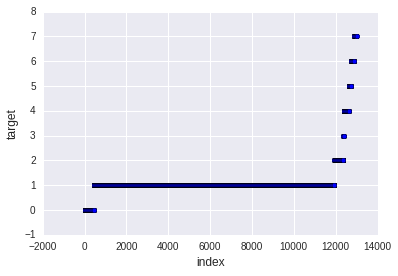

In [11]:
plt.figure(figsize=(6, 4))
plt.scatter(range(data_cat.shape[0]), np.sort(data_cat.type.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('target', fontsize=12)
plt.show()

<p>Как видно из графика данные сильно не сбалансированны</p>

<h2>Юзаем TF-IDF<h2>

In [12]:
import nltk

In [185]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [52]:
data_cat['title'][:130]

0      Muslims BUSTED: They Stole Millions In Gov’t B...
1      Re: Why Did Attorney General Loretta Lynch Ple...
2      BREAKING: Weiner Cooperating With FBI On Hilla...
3      PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...
4      FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...
5      Hillary Goes Absolutely Berserk On Protester A...
6      BREAKING! NYPD Ready To Make Arrests In Weiner...
7      WOW! WHISTLEBLOWER TELLS CHILLING STORY Of Mas...
8      BREAKING: CLINTON CLEARED...Was This A Coordin...
9      EVIL HILLARY SUPPORTERS Yell "F*ck Trump"…Burn...
10     YIKES! HILLARY GOES OFF THE RAILS…Pulls A Howa...
11     SAY GOODBYE! These 23 Hollywood Celebs Threate...
12     NOT KIDDING: Colleges Give Students “Safe Spac...
13     BOOM! MATH SHOWS Trump Would Have Beaten Obama...
14     BOOM! This Is How President Reagan Handled Pro...
15     TRUMP SUPPORTER GOT NUTS On MSNBC Reporter Cov...
16     TOMI LAHREN Has Special Message For Celebritie...
17     #BoycottComedian…ROBERT 

In [13]:
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

<p>Очищаем текст от линих символов и нормализуем слова</p>

In [14]:
import re
tit = ""
mas = data_cat['title']
for word in mas:
    reg = re.compile('[^a-zA-Z.!?; ]')
    tit += reg.sub('', word)


In [15]:
tit2 = ""
mas = data_cat['title']
for word in tit:
    reg = re.compile('[^a-zA-Z ]')
    tit2 += reg.sub('.', word)

In [61]:
tit2

'Muslims BUSTED They Stole Millions In Govt BenefitsRe Why Did Attorney General Loretta Lynch Plead The Fifth.BREAKING Weiner Cooperating With FBI On Hillary Email InvestigationPIN DROP SPEECH BY FATHER OF DAUGHTER Kidnapped And Killed By ISIS I have voted for Donald J. Trump.  percentfedUp.comFANTASTIC. TRUMPS  POINT PLAN To Reform Healthcare Begins With A Bombshell.  percentfedUp.comHillary Goes Absolutely Berserk On Protester At Rally. VideoBREAKING. NYPD Ready To Make Arrests In Weiner CaseHillary Visited Pedophile Island At Least  TimesMoney Laundering Underage Sex PayforPlayProof of Inappropriate Handling Classified Information  percentfedUp.comWOW. WHISTLEBLOWER TELLS CHILLING STORY Of Massive Voter Fraud Trump Campaign Readies Lawsuit Against FL Sec Of Elections In Critical District VIDEO  percentfedUp.comBREAKING CLINTON CLEARED...Was This A Coordinated Last Minute Trick To Energize Hillarys Base.  percentfedUp.comEVIL HILLARY SUPPORTERS Yell Fck TrumpBurn Truck Of Daddy Fishi

In [16]:
final_title = ""
ps = PorterStemmer()
words = word_tokenize(tit2)   
for word in words:
    final_title += ps.stem(word) + " "

<p>Поиск оптимальных n-грамм</p>

In [17]:
vectorizer_title_ch = TfidfVectorizer(analyzer='char',min_df=4, max_df=0.4, ngram_range=(3, 5))

In [18]:
title_TF_ch = vectorizer_title_ch.fit_transform(tit2.split('.'))

In [19]:
vectorizer_title_ch.vocabulary_

{u'gai': 21688,
 u't imm': 50736,
 u'gag': 21684,
 u'woods': 57054,
 u't imp': 50737,
 u'xodu': 57340,
 u'p los': 41683,
 u'ok an': 38690,
 u'gab': 21676,
 u'ok at': 38691,
 u'wood ': 57053,
 u'cane ': 11063,
 u'tumes': 53485,
 u'targe': 51345,
 u'kid ': 28897,
 u'rrass': 46024,
 u' birt': 672,
 u'tume ': 53484,
 u'sexua': 48584,
 u' bird': 671,
 u'kids': 28900,
 u'kidn': 28898,
 u'lence': 30347,
 u'dne': 14270,
 u'dna': 14261,
 u'dnc': 14266,
 u'dno': 14277,
 u'dni': 14276,
 u'dnt': 14278,
 u'bly s': 10333,
 u'dny': 14286,
 u'l cit': 29239,
 u'l civ': 29240,
 u' labe': 2679,
 u'alaqs': 6886,
 u'om is': 38985,
 u'bly t': 10334,
 u'n dec': 33745,
 u'ey hi': 20027,
 u'ey ha': 20026,
 u'krain': 29017,
 u'hieve': 23776,
 u'wrong': 57094,
 u'sov ': 49392,
 u'fir': 20871,
 u'fis': 20886,
 u'fiv': 20900,
 u'fit': 20891,
 u'fix': 20903,
 u'fic': 20797,
 u'fia': 20796,
 u'fif': 20826,
 u'fig': 20829,
 u'fid': 20813,
 u'fie': 20816,
 u'fin': 20850,
 u'fil': 20834,
 u'ankof': 7722,
 u'sovi': 4939

In [21]:
vectorizer_text_ngram = TfidfVectorizer( min_df=4, max_df=0.4, ngram_range=(1, 3))

In [22]:
title_TF_ngram = vectorizer_text_ngram.fit_transform(tit2.split('.'))

In [23]:
vectorizer_text_ngram.vocabulary_

{u'woods': 7569,
 u'sexual assault': 5652,
 u'to prevent': 6671,
 u'the real': 6349,
 u'wednesday': 7335,
 u'election by': 1946,
 u'replaced': 5301,
 u'kids': 3568,
 u'dna': 1768,
 u'dnc': 1770,
 u'clinton donors': 1185,
 u'illegal aliens': 3085,
 u'wrong': 7619,
 u'will make': 7481,
 u'welcomes': 7351,
 u'fit': 2357,
 u'fix': 2359,
 u'found manipulating': 2506,
 u'to find': 6606,
 u'needed': 4205,
 u'the horizon': 6279,
 u'journalists are': 3510,
 u'in history': 3154,
 u'tech': 6106,
 u'to resume': 6691,
 u'nature': 4189,
 u'video american': 7120,
 u'of their': 4488,
 u'there will': 6437,
 u'obese': 4394,
 u'corporate': 1399,
 u'crowd': 1485,
 u'from donald trump': 2540,
 u'badges rather than': 584,
 u'reopens hillary email': 5294,
 u'raped': 5169,
 u'petition to': 4811,
 u'marlenecomment': 3887,
 u'to illegals': 6634,
 u'tens of': 6121,
 u'chair': 1051,
 u'minute': 4034,
 u'on trumps': 4596,
 u'following': 2389,
 u'and silver': 328,
 u'fbi probe': 2274,
 u'did you': 1716,
 u'jim': 34

In [28]:
vectorizer_text = TfidfVectorizer(min_df=4, max_df=0.4, ngram_range=(1, 3))

In [31]:
title_TF = vectorizer_text.fit_transform(final_title.split('.'))

In [32]:
vectorizer_text.vocabulary_

{u'sexual assault': 5492,
 u'of justic': 4349,
 u'to prevent': 6497,
 u'thi time': 6291,
 u'wednesday': 7128,
 u'controversi': 1362,
 u'is rig': 3318,
 u'dna': 1734,
 u'dnc': 1736,
 u'wrong': 7406,
 u'fit': 2296,
 u'fix': 2298,
 u'of the week': 4395,
 u'to find': 6431,
 u'for make': 2368,
 u'master': 3819,
 u'mind kommonsentsjanecom': 3939,
 u'do noth': 1740,
 u'tech': 5926,
 u'restaur': 5203,
 u'reduc the': 5111,
 u'extend': 2137,
 u'video american': 6929,
 u'of their': 4397,
 u'regul': 5125,
 u'anger': 344,
 u'crowd': 1453,
 u'switch trump vote': 5881,
 u'from donald trump': 2487,
 u'endors hillari clinton': 2003,
 u'fabric': 2145,
 u'mirror': 3949,
 u'chain': 1031,
 u'chair': 1032,
 u'economi than': 1866,
 u'contribut more to': 1354,
 u'im grab': 3022,
 u'and silver': 327,
 u'fbi probe': 2221,
 u'did you': 1676,
 u'jim': 3419,
 u'whi did': 7197,
 u'black voter': 732,
 u'war iii': 7043,
 u'palestinian want to': 4624,
 u'the mind kommonsentsjanecom': 6124,
 u'foreign agent on': 2428,


In [33]:
title_TF.shape

(3367, 7490)

In [34]:
data_fake = data_cat[data_cat['type'] == 1]
data_fake['main_img_url'].count()

11492

In [35]:
data_cat['main_img_url'] = data_cat['main_img_url'].apply(lambda x: 0 if x=="" else 1 ).astype(int)

In [68]:
data_cat['main_img_url'].value_counts()

1    9356
0    3643
Name: main_img_url, dtype: int64

In [36]:
data_cat = data_cat.drop(['uuid','thread_title','text'], axis=1)

In [37]:
data_cat.head()

,author,published,title,language,crawled,site_url,country,main_img_url,type
0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,1,0
1,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,1,0
2,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,1,0
3,Fed Up,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,english,2016-11-01T15:46:26.304+02:00,100percentfedup.com,US,1,0
4,Fed Up,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,english,2016-11-01T23:59:42.266+02:00,100percentfedup.com,US,1,0


In [38]:
feats = ['author', 'language', 'site_url', 'country']
data_cat[feats][:5]

,author,language,site_url,country
0,Barracuda Brigade,english,100percentfedup.com,US
1,reasoning with facts,english,100percentfedup.com,US
2,Barracuda Brigade,english,100percentfedup.com,US
3,Fed Up,english,100percentfedup.com,US
4,Fed Up,english,100percentfedup.com,US


In [39]:
vectorizer_feats = DictVectorizer()

In [40]:
data_cat_feats = vectorizer_feats.fit_transform(data_cat.ix[:, feats].T.to_dict().values())

In [41]:
data_cat_feats.shape

(12999, 2545)

<p>Преобразование времени в корректный формат</p>

In [42]:
from datetime import datetime
format_str = "%Y-%m-%dT%H:%M:%S"

i = 0
for date_str in data_cat['published']:
    date_str2 = date_str[0:19]
    data_cat.loc[i,'published'] =  datetime.strptime(date_str2, format_str)
    i = i+1
i=0
for date_str in data_cat['crawled']:
    date_str2 = date_str[0:19]
    data_cat.loc[i,'crawled'] = datetime.strptime(date_str2, format_str)
    i = i+1

data_cat.head()

,author,published,title,language,crawled,site_url,country,main_img_url,type
0,Barracuda Brigade,2016-10-26 21:41:00,Muslims BUSTED: They Stole Millions In Gov’t B...,english,2016-10-27 01:49:27,100percentfedup.com,US,1,0
1,reasoning with facts,2016-10-29 08:47:11,Re: Why Did Attorney General Loretta Lynch Ple...,english,2016-10-29 08:47:11,100percentfedup.com,US,1,0
2,Barracuda Brigade,2016-10-31 01:41:49,BREAKING: Weiner Cooperating With FBI On Hilla...,english,2016-10-31 01:41:49,100percentfedup.com,US,1,0
3,Fed Up,2016-11-01 05:22:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,english,2016-11-01 15:46:26,100percentfedup.com,US,1,0
4,Fed Up,2016-11-01 21:56:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,english,2016-11-01 23:59:42,100percentfedup.com,US,1,0


<p>Создадим новую переменную, она будет определять, время от момента публикации до выхода в топ</p>

In [43]:
data_cat['delta_time'] = data_cat['crawled'] - data_cat['published']


In [44]:
data_cat = data_cat.drop(['published','crawled','title'], axis=1)
#data_cat = data_cat.drop('crawled', axis=1)

In [45]:
data_cat = data_cat.drop(feats, axis=1)

In [159]:
data_cat.dtypes

main_img_url              int64
type                      int64
delta_time      timedelta64[ns]
dtype: object

In [46]:

data_new = pd.concat([data_cat,data_real], axis=1)

In [47]:
data_new.head()

,main_img_url,type,delta_time,ord_in_thread,domain_rank,spam_score,replies_count,participants_count,likes,comments,shares
0,1,0,04:08:27,0,25689,0.000,0,1,0,0,0
1,1,0,00:00:00,0,25689,0.000,0,1,0,0,0
2,1,0,00:00:00,0,25689,0.000,0,1,0,0,0
3,1,0,10:24:26,0,25689,0.068,0,0,0,0,0
4,1,0,02:03:42,0,25689,0.865,0,0,0,0,0


<h2>Визуализация !</h2>

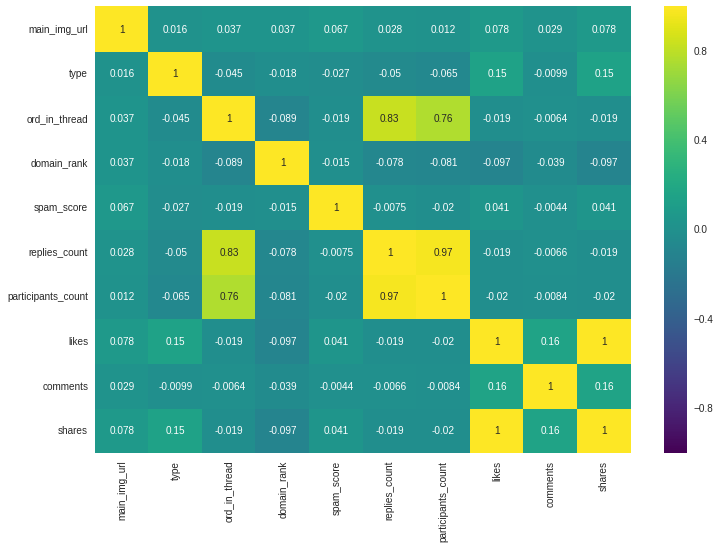

In [79]:
corr = data_new.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap='viridis', annot=True )

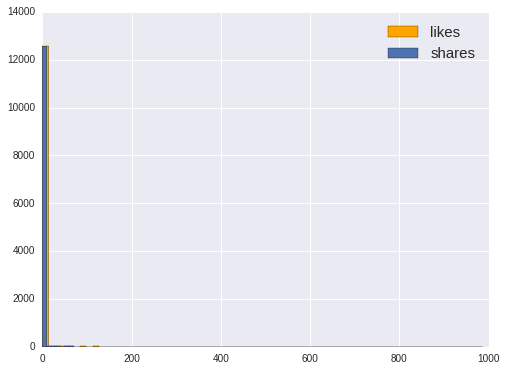

In [31]:
fig, ax = plt.subplots(1, figsize=(8,6))
ax = data['likes'].hist(bins=70, color='orange')
ax = data['shares'].hist(bins=100)
ax.legend(['likes', 'shares'], fontsize=15);

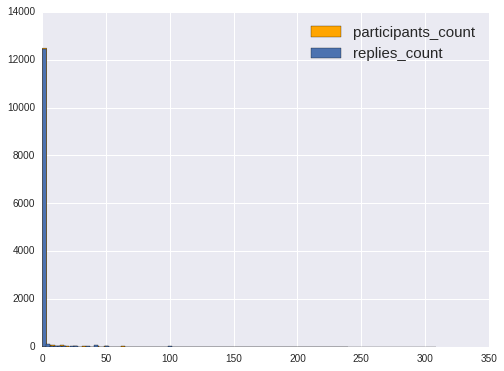

In [32]:
fig, ax = plt.subplots(1, figsize=(8,6))
ax = data['participants_count'].hist(bins=70, color='orange')
ax = data['replies_count'].hist(bins=100)
ax.legend(['participants_count', 'replies_count'], fontsize=15);

In [48]:
data_new['follow'] = data_new['likes']+data_new['shares']+data_new['comments']

In [49]:
data_new = data_new.drop(['likes','shares','comments'], axis=1)

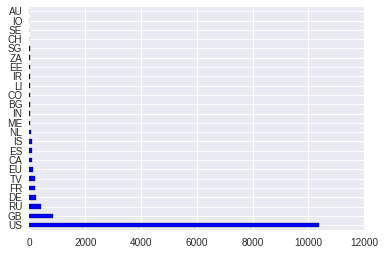

In [35]:
data['country'].value_counts().plot.barh();

<h2>Обучение модели</h2>

In [50]:
data_new['delta_time'] = data_new['delta_time'] / np.timedelta64(1, 's')
y = data_new['type']

In [51]:
data_new = data_new.drop('type', axis=1)

In [52]:
diff_n_rows = data_new.shape[0] - title_TF.shape[0]

In [53]:
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from scipy.sparse import vstack
TF_new = vstack((title_TF, csr_matrix((diff_n_rows, title_TF.shape[1])))) 

In [54]:
data_all = hstack([data_cat_feats,data_new,TF_new]) #!!! Ничего не менять выше

In [55]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_all, y, 
                                                    test_size=0.2, 
                                                    random_state=17,
                                                   stratify = y)

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [56]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.fit_transform(X_test)

In [57]:
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier( random_state=17).fit(X_train_sc, y_train)

model_rf.feature_importances_

array([  5.83153265e-03,   3.11871542e-06,   1.17932575e-02, ...,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00])

<p>К сожалению мы не сможем оценить важность признаков из за плохой интрепритации массивов (</p>

<p>В качестве отправной точки построим дефолтовые модели:<br>
-LogisticRegression<br>
-RandomForest<br>
-GradientBoosting</p>

In [58]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.metrics import roc_auc_score, auc, roc_curve

In [59]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression

forest = RandomForestClassifier(n_estimators=50, random_state=17, 
                            class_weight='balanced')
boosting = GradientBoostingClassifier(random_state=17)
logit = LogisticRegression(random_state=17, class_weight= 'balanced')

print('RandomForest:')
forest.fit(X_train_sc, y_train)
y_pred = forest.predict(X_test_sc)
score_f1 = f1_score(y_test, y_pred, average='weighted')
print('f1_score = {}'.format(score_f1))

#print('GradientBoosting:')
#boosting.fit(X_train_sc.todense(), y_train)
#y_pred = boosting.predict(X_test_sc.todense())
#score_f1 = f1_score(y_test, y_pred, average='weighted')
#print('f1_score = {}'.format(score_f1))

print('LogisticRegressor:')
logit.fit(X_train_sc, y_train)
y_pred = logit.predict(X_test_sc)
score_f1 = f1_score(y_test, y_pred, average='weighted')
print('f1_score = {}'.format(score_f1))

RandomForest:
f1_score = 0.987883194254
LogisticRegressor:
f1_score = 0.997725796249


<p>Видно, что модели очень сильно <b>переобучаются</b> из-за сильной не сбалансированности классов</p>

In [63]:
import heapq
num_2_words = {
    v: k
    for k, v in vectorizer_text_ngram.vocabulary_.iteritems()
}

W = logit.coef_.shape[1]
for c in logit.classes_:
    topic_words = [
        num_2_words[w_num]
        for w_num in heapq.nlargest(10, range(W), key=lambda w: logit.coef_[c, w])
    ]
    print ',  '.join(topic_words)

gang,  for chang,  forgotten,  gate,  fixer,  fleet,  abc new,  by russia,  boss,  deplor
first day,  gener and admir,  fire,  foto,  finest new,  fix,  fix is,  form,  founder,  from us
forum,  flee,  flu,  for the first,  fking,  film is,  achiev,  forc them to,  dinner,  email confirm
from donald,  fli,  campaign for,  flag,  detain,  fifth,  compani,  email from,  at site,  david duke and
for month,  found on,  back on,  for civil unrest,  as the,  del,  ban,  aftermath of,  associ,  comcom on
forc out by,  brutal,  comey reopen,  eastern,  after be,  be year,  geopolit,  due to fear,  congressman,  as russian


KeyError: 9212

<p>Покажем, что модель переобучается</p>

In [64]:
from sklearn.pipeline import Pipeline

In [77]:
pipeline = Pipeline([ ("algo", LogisticRegression())])

In [78]:
pipeline.fit(X_train_sc, y_train)

Pipeline(steps=[('algo', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [79]:
accuracy_score(pipeline.predict(X_train_sc), y_train)

1.0

In [80]:
accuracy_score(pipeline.predict(X_test_sc), y_test)

0.99730769230769234

In [81]:
from sklearn.model_selection import cross_val_score
algo = LogisticRegression()
arr = cross_val_score(algo, data_all, y, cv=5, scoring='accuracy')
print arr
print np.mean(arr)

[ 0.87903226  0.88504421  0.88841862  0.87836798  0.89064305]
0.884301223883


In [82]:
algo.fit(X_train_sc, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

0.99730769230769234

<p>Для борьбы с переобучением будем использовать сверхслучайные деревья и гребневую регрессию</p>

In [84]:
from sklearn.ensemble import ExtraTreesClassifier
extra_model = ExtraTreesClassifier()
extra_model.fit(X_train_sc, y_train)
y_pred = extra_model.predict(X_test_sc)
score_f1 = f1_score(y_test, y_pred, average='weighted')
print('f1_score = {}'.format(score_f1))

f1_score = 0.997261057375


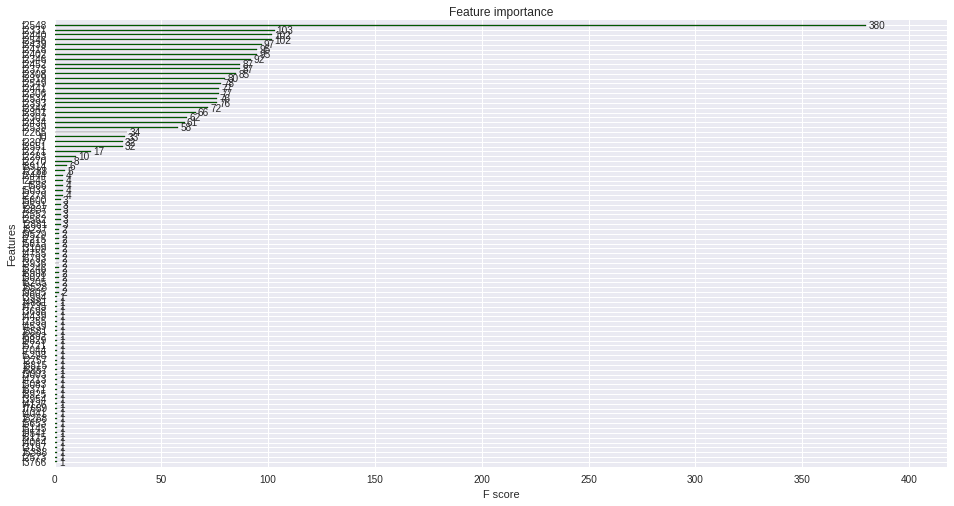

In [85]:
import xgboost as xgb

model_xgb = xgb.XGBClassifier().fit(X_train_sc, y_train)

plt.figure(figsize(16,8))
xgb.plot_importance(model_xgb, color='green')
plt.show()

In [104]:
sort(model_xgb.feature_importances_)

array([ 0.00041911,  0.00041911,  0.00041911,  0.00041911,  0.00041911,
        0.00041911,  0.00041911,  0.00041911,  0.00041911,  0.00041911,
        0.00041911,  0.00041911,  0.00041911,  0.00041911,  0.00041911,
        0.00041911,  0.00041911,  0.00041911,  0.00041911,  0.00041911,
        0.00041911,  0.00041911,  0.00041911,  0.00041911,  0.00041911,
        0.00041911,  0.00041911,  0.00041911,  0.00041911,  0.00041911,
        0.00041911,  0.00041911,  0.00041911,  0.00041911,  0.00041911,
        0.00083822,  0.00083822,  0.00083822,  0.00083822,  0.00083822,
        0.00083822,  0.00083822,  0.00083822,  0.00083822,  0.00083822,
        0.00083822,  0.00083822,  0.00083822,  0.00083822,  0.00125733,
        0.00125733,  0.00125733,  0.00125733,  0.00125733,  0.00125733,
        0.00167645,  0.00167645,  0.00167645,  0.00167645,  0.00167645,
        0.00209556,  0.00251467,  0.00335289,  0.00419112,  0.0071249 ,
        0.01341157,  0.01341157,  0.01383068,  0.01424979,  0.02

In [87]:
thresholds = sort(model_xgb.feature_importances_)
thresholds = thresholds[-50:]

In [88]:
thresholds

array([ 0.00083822,  0.00083822,  0.00083822,  0.00083822,  0.00083822,
        0.00083822,  0.00083822,  0.00083822,  0.00125733,  0.00125733,
        0.00125733,  0.00125733,  0.00125733,  0.00125733,  0.00167645,
        0.00167645,  0.00167645,  0.00167645,  0.00167645,  0.00209556,
        0.00251467,  0.00335289,  0.00419112,  0.0071249 ,  0.01341157,
        0.01341157,  0.01383068,  0.01424979,  0.02430847,  0.0255658 ,
        0.02598491,  0.02766136,  0.03017603,  0.03185247,  0.03185247,
        0.03227158,  0.03227158,  0.0326907 ,  0.03352892,  0.03562447,
        0.0364627 ,  0.0364627 ,  0.03855826,  0.03981559,  0.03981559,
        0.04065381,  0.04274937,  0.04274937,  0.04316848,  0.15926236], dtype=float32)

In [89]:
from sklearn.feature_selection import SelectFromModel
selection = SelectFromModel(model_xgb, prefit=True)
X_new = selection.transform(X_train_sc)

In [90]:
X_test_50 = selection.transform(X_test_sc)
X_train_50 = X_new

In [91]:
model_xgb = xgb.XGBClassifier().fit(X_train_50, y_train)
y_pred = model_xgb.predict(X_test_50)
score_f1 = f1_score(y_test, y_pred, average='weighted')
print('f1_score = {}'.format(score_f1))

f1_score = 0.998427592483


In [92]:
data_50 =  selection.transform(data_all)

In [94]:
from sklearn.model_selection import cross_val_score
algo = LogisticRegression()
arr = cross_val_score(algo, data_50, y, cv=5, scoring='accuracy')
print arr
print np.mean(arr)

[ 0.88172043  0.88542868  0.88841862  0.87451886  0.88525221]
0.883067761737


In [219]:
X_train_50.shape

(10399, 91)

<p>Попробуем снизить размернось, с помощью PCA</p>

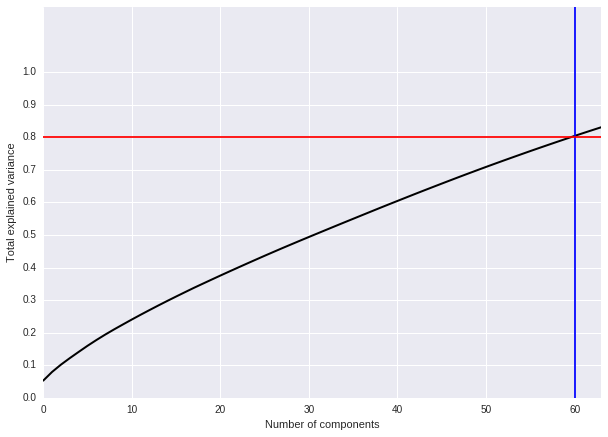

In [96]:

from sklearn import decomposition
pca = decomposition.PCA().fit(X_train_50.todense())
    # смог посчитать
plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 63)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(60, c='b')
plt.axhline(0.8, c='r')
plt.show();

In [97]:
pca = decomposition.PCA(n_components=50)
X_centered = data_50 - data_50.mean(axis=0)
pca.fit(X_centered)
data_pca = pca.transform(X_centered)

In [98]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(data_pca, y, 
                                                    test_size=0.2, 
                                                    random_state=17,
                                                   stratify = y)

In [101]:
from sklearn.ensemble import ExtraTreesClassifier
extra_model = ExtraTreesClassifier()
extra_model.fit(X_train_pca, y_train_pca)
y_pred = extra_model.predict(X_test_pca)
score_f1 = f1_score(y_test_pca, y_pred, average='weighted')
print('f1_score = {}'.format(score_f1))

f1_score = 0.99881304004


In [102]:
data_pca.shape

(12999, 50)

In [105]:
from sklearn.model_selection import cross_val_score
algo = LogisticRegression()
arr = cross_val_score(algo, data_pca, y, cv=5, scoring='accuracy')
print arr
print np.mean(arr)

[ 0.94239631  0.99346405  0.9957676   0.96420323  0.93184444]
0.965535127544


In [232]:
from scipy.stats import uniform as sp_rand
from sklearn.linear_model import RidgeClassifier
from sklearn.grid_search import RandomizedSearchCV

model = RidgeClassifier(alpha=70)
model.fit(X_train_pca, y_train_pca)
y_pred = model.predict(X_test_pca)
score_f1 = f1_score(y_test_pca, y_pred,average='weighted')
print('f1_score = {}'.format(score_f1))

f1_score = 0.983653001644


/usr/local/lib/python2.7/dist-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<p>Эо несильно помголо из-за сильной несбалансированности классов </p>